In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
train_label =pd.read_csv('../input/planet-understanding-the-amazon-from-space/train_v2.csv/train_v2.csv')

In [5]:
train_label.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
train_label.shape

(40479, 2)

In [7]:
Path ='../input/planets-dataset/planet/planet/train-jpg'

In [8]:
import cv2

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

# CUSTOM
def cv2_to_plt(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def dehaze(image_path:Path, output_path:Path):
    src = cv2.imread(str(image_path))

    I = src.astype('float64')/255
    dark = DarkChannel(I,15)
    A = AtmLight(I,dark)
    te = TransmissionEstimate(I,A,15)
    t = TransmissionRefine(src,te)
    J = Recover(I,t,A,0.1)
    
    cv2.imwrite(str(output_path/image_path.name), J*255);

In [9]:
import math
fn = '../input/planet/Train/train_10.jpg'

src = cv2.imread(fn)

I = src.astype('float64')/255

dark = DarkChannel(I,15)
A = AtmLight(I,dark)
te = TransmissionEstimate(I,A,15)
t = TransmissionRefine(src,te)
J = Recover(I,t,A,0.1);

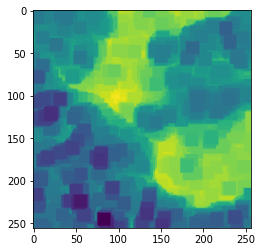

In [10]:
import matplotlib.pyplot as plt
plt.imshow(dark);

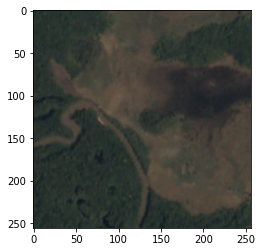

In [11]:
plt.imshow(cv2_to_plt(src));

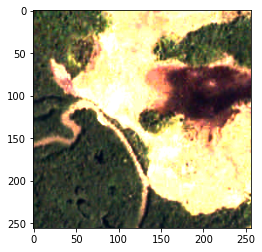

In [12]:
plt.imshow(cv2_to_plt(J.astype('float32')))

In [13]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras.models as models
import keras.layers as layers
from keras import backend

In [14]:
test_df=pd.read_csv('/kaggle/input/planet-understanding-the-amazon-from-space/test_v2_file_mapping.csv/test_v2_file_mapping.csv')

In [15]:
def tag_mapping(data):
    labels=set()
    for i in range(len(data)):
        tags=data['tags'][i].split(' ')
        labels.update(tags)
    labels=list(labels)
    labels.sort()
    labels_dict={labels[i]:i for i in range(len(labels))}
    inv_labels={i:labels[i] for i in range(len(labels))}
    return labels_dict,inv_labels

In [16]:
label_map,invmap=tag_mapping(train_label)

In [17]:
def file_mapping(data):
    mapping={}
    for i in range(len(data)):
        name,tags=train_label['image_name'][i],train_label['tags'][i]
        mapping[name]=tags.split(' ')
    return mapping

In [18]:
def one_hot_encode(tags, mapping):
    encoding = np.zeros(len(mapping), dtype='uint8')
    for tag in tags:
        encoding[mapping[tag]] = 1
    return encoding

In [19]:
def load_dataset(path,file_mapping,tag_mapping):
    photos,targets=list(),list()
    for filename in os.listdir(path):
        photo=load_img(path+filename,target_size=(75,75))
        photo=img_to_array(photo,dtype='uint8')
        tags=file_mapping[filename[:-4]]
        target=one_hot_encode(tags,tag_mapping)
        photos.append(photo)
        targets.append(target)
    X=np.asarray(photos,dtype='uint8')
    y=np.asarray(targets,dtype='uint8')
    return X,y

In [20]:
tags_mapping,_=tag_mapping(train_label)
files_mapping=file_mapping(train_label)
path='/kaggle/input/planets-dataset/planet/planet/train-jpg/'
X,y=load_dataset(path,files_mapping,tags_mapping)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, RMSprop

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [23]:
def fbeta(y_true, y_pred, beta=2):
    y_pred = backend.clip(y_pred, 0, 1)

    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

In [24]:
from tensorflow.keras.applications import InceptionV3
model=InceptionV3(input_shape=(75,75,3),include_top=False)
for layer in model.layers:
    layers.trainable=False
last_layer=model.get_layer('mixed7')
last_output=last_layer.output
    
x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dense(512,activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(17,activation='sigmoid')(x)
model=models.Model(model.inputs,x)
model.compile(optimizer=RMSprop(lr=0.0001),loss='binary_crossentropy',metrics=[fbeta])

2022-09-18 18:26:25.532818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 18:26:25.665593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 18:26:25.666379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 18:26:25.668190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [25]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,horizontal_flip=True, vertical_flip=True, rotation_range=90)
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

In [26]:
train_gen=train_datagen.flow(X_train,y_train,batch_size=64)
test_gen=test_datagen.flow(X_test,y_test,batch_size=64)

In [27]:
history = model.fit(train_gen,steps_per_epoch=506,validation_data=test_gen, validation_steps=127, epochs=50, verbose=0)

2022-09-18 18:26:38.409753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-18 18:26:47.901249: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [28]:
loss, fbeta =model.evaluate_generator(test_gen, steps=8, verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, fbeta))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> loss=0.140, fbeta=0.851


In [29]:
history.history['fbeta']

[0.8273005485534668]

In [30]:
test_data1='/kaggle/input/planets-dataset/planet/planet/test-jpg/'
test_data2='/kaggle/input/planets-dataset/test-jpg-additional/test-jpg-additional/'

In [32]:
submission_df=pd.read_csv('/kaggle/input/planet-understanding-the-amazon-from-space/sample_submission_v2.csv/sample_submission_v2.csv')

In [34]:
photo_test=[]
for filename in submission_df['image_name']:
    if filename[:1]=='t':
        img=load_img(test_data1+filename+'.jpg',target_size=(75,75))
    elif filename[:1]=='f':
        img=load_img(test_data2+filename+'.jpg',target_size=(75,75))
    ph=img_to_array(img,dtype='uint8')
    photo_test.append(ph)

In [35]:
test_X=np.asarray(photo_test,dtype='uint8')

In [37]:
image_gen_test=ImageDataGenerator(rescale=1/255.0)
test_data_gen=image_gen_test.flow(test_X,shuffle=False,batch_size=64)

In [38]:
prediction=model.predict(test_data_gen)

In [40]:
answer=pd.DataFrame(prediction,columns=tags_mapping.keys())

In [41]:
tags=answer.columns
pred_tags=answer.apply(lambda x: ' '.join(tags[x>0.5]),axis=1)

In [42]:
pred_tag=pd.DataFrame(pred_tags,columns=['tags'])

In [43]:
submission_df['tags']=pred_tag['tags']

In [44]:
submission_df.to_csv('my_prediction.csv',index=False)

In [45]:
submission_df.head(10)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,clear primary
4,test_4,partly_cloudy primary
5,test_5,clear primary
6,test_6,partly_cloudy primary
7,test_7,clear habitation road
8,test_8,clear primary
9,test_9,primary
